# Implementing Linear Regression

Regression, as opposed to classification, is a method to predict a real number for each data point based on its features. This post will focus on least squares linear regression, which falls into our framework of convex linear models. 

The following post begins by implementing least-squares linear regression in two ways: using the analytical formula for the optimal weight vector (requiring matrix inversion and several matrix multiplications), and using the formula for the gradient of the loss function to implement gradient descent for linear regression. 

To view the source code, pelase follow this link: 

## Set up

First, import required packages: 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
import pandas as pd
from sklearn.model_selection import train_test_split

Now, create a function to make both testing and validation data to test the implementation:

In [2]:
def pad(X): #ensure X is the proper shape
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

Visualize the testing and validation data: 

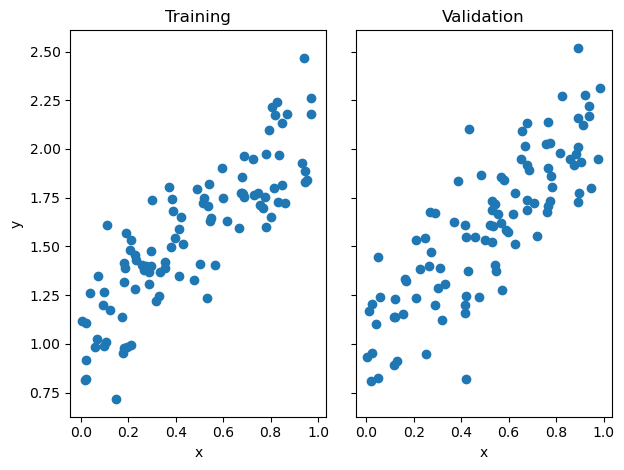

In [3]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

It is only possible to easily visualize this problem when p_features = 1.
Now, let's implement linear regression using two different methods. 

## Implementation: Analytical Formula

We begin by implementing the analytical formula for the optimal weight vector w_hat from the lecture notes. The following is the explicit formula for w: 

$$\\{\\{wHat}}={(X^TX)^{-1}X^Ty}$$

First, auto-refresh the source code: 

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from linear_regression import LinearRegression #call method from source code
LR = LinearRegression()
LR.fit_analytical(X_train, y_train) #use implementation of above formula 

print(f"Training score = {LR.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR.score(X_val, y_val).round(4)}")

Training score = 0.7271
Validation score = 0.6894


The score (coefficient) is always smaller than 1, with a higher value indicating better predictive performance. As usual, gaps between the training and validation scores suggest the possibility of overfitting, although further investigation is required to see whether improvement on validation data is possible. In this case, the gap between the scores is relatively small. 

The estimated weight vector w is: 

In [6]:
LR.w

array([1.07026516, 1.05566706])

Now, let's visualize the performance of the analytic formula on our training and validation data. 

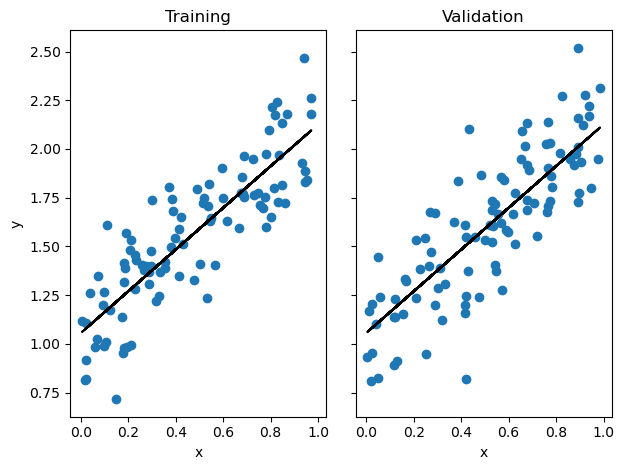

In [7]:
# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
axarr[0].plot(X_train, LR.predict(X_train), color = "black")
axarr[1].plot(X_val, LR.predict(X_val), color = "black")
plt.tight_layout()

These predicted regression lines coorespond pretty well with both the training and test data! Let's compare the weights and scores using the analytical method to those using gradient descent. 

## Implementation: Gradient Descent

The following is the formula for the gradient that our source code implements: 

$$\\{\\{w^{(t+1)}}}={w^{(t)}- \alpha (Pw ^{(t)}-q})$$

Now, let's see if we get the same weight vector from this method using the same testing and training data: 

In [8]:
LR2 = LinearRegression() #call method

LR2.fit_gradient(X_train, y_train, alpha = 0.01, max_iter = 100) #gradient does not have the divide by points thing, need to adapt the learning rate to account for fact gradietn is too bigh .
LR2.w

array([1.07026515, 1.05566706])

This method lends the same value for w as the analytic method. Now, let's visualize how the score using gradient descent changes over time. 

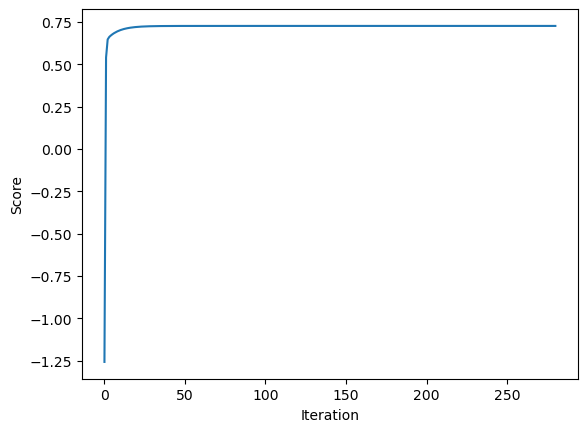

In [9]:
plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")

As pictured, the score increases monotonically in each iteration, increasing rapidly until about 50 iterations, and then increasing at a much slower rate. Now, we will experiment with increasing the number of features. 

## Experiments

In the following experiment, I allow p_features, the number of features used, to increase, while holding n_train, the number of training points, constant. I then assess and explain the differences between the training and validation scores. 

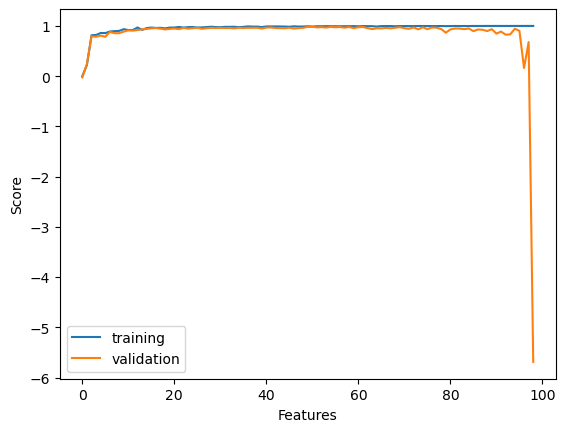

In [10]:
LR_ex = LinearRegression()

n_train = 100
n_val = 100
noise = 0.2

trainScoreArray = []
testScoreArray = []

for feature in range(0,(n_train-1)):
    p_features = feature
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    LR_ex.fit_analytical(X_train, y_train) 
    trainScore = LR_ex.score(X_train, y_train).round(4)
    testScore = LR_ex.score(X_val, y_val).round(4)
    trainScoreArray.append(trainScore)
    testScoreArray.append(testScore)
plt.plot(trainScoreArray, label = 'training')
plt.plot(testScoreArray, label = 'validation')
labels = plt.gca().set(xlabel = "Features", ylabel = "Score")
plt.legend(loc="lower left")

plt.show()    
    

As the number of features in this experiment increases, the validation score tends to decrease relative to the training score. It follows that increasing the number of features leads to overfitting, where the model is too finely tuned to the training data. An overfit model struggles to simply representing overarching trends. In this case, as the number of features approaches the number of training points, the model began scoring much more highly on the training data (show in blue) while not achieving as high of an accuracy score for the test data (shown in orange). Next, we will try to combat overfit models using LASSO regularization.  

## LASSO Regularization

The LASSO algorithm uses a modified loss function with a regularization term, the effect of which  is to make the entries of the weight vector w small. The LASSO algorithm tends to force each entry of the weight vector to be exactly zero. This is a helpful property in overfitted problems, especially when the number of features p is larger than the number of data points n.

In [11]:
L = Lasso(alpha = 0.001)

Here, alpha controls the strength of the regularization. Now, let’s fit this model on some data and check the coefficients:

In [12]:
p_features = n_train - 1
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
L.fit(X_train, y_train)

Lasso(alpha=0.001)

Now, let's calculate the score: 

In [13]:
L.score(X_val, y_val)

0.8268398547106713

The LASSO algorithm yields a high validation score.

Now, I will replicate the same experiment I did with linear regression, increasing the number of to exceed the number of training points using the LASSO algorithm. The following also experiments with different values of alpha. 

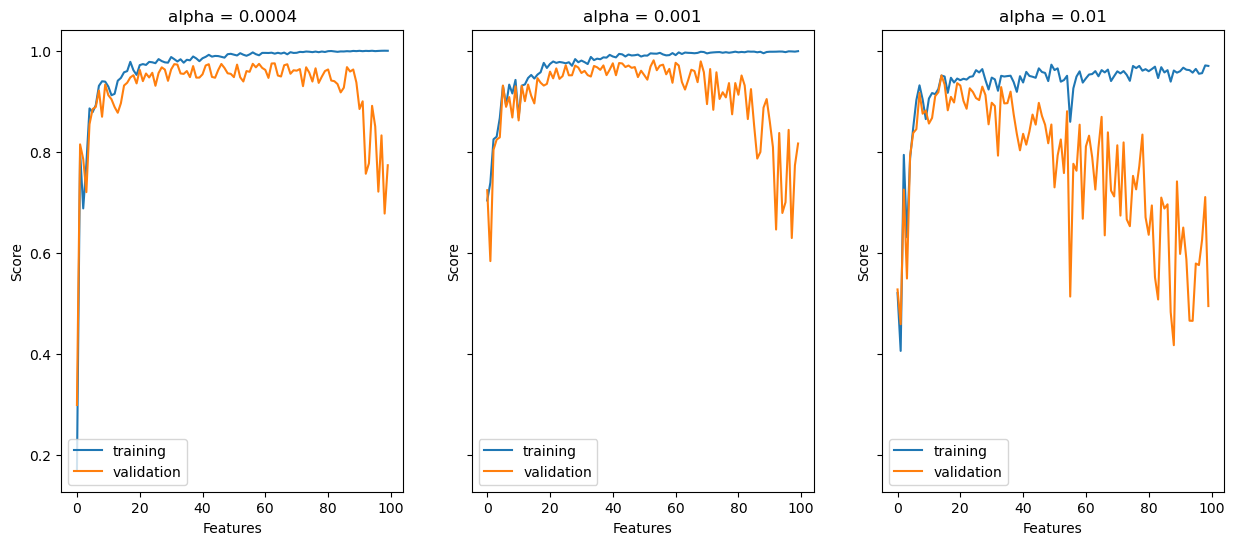

In [14]:
L1 = Lasso(alpha = 0.001)

n_train = 100
n_val = 100
noise = 0.2

trainScoreArray = []
testScoreArray = []

#alpha = 0.001
for feature in range(1,(n_train+1)): 
    p_features = feature
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L1.fit(X_train, y_train) 
    trainScore = L1.score(X_train, y_train).round(4)
    testScore = L1.score(X_val, y_val).round(4)
    trainScoreArray.append(trainScore)
    testScoreArray.append(testScore)
    
#alpha = 0.01
L2 = Lasso(alpha = 0.01)
trainScoreArray2 = []
testScoreArray2 = []

for feature in range(1,(n_train+1)): 
    p_features = feature
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L2.fit(X_train, y_train) 
    trainScore2 = L2.score(X_train, y_train).round(4)
    testScore2 = L2.score(X_val, y_val).round(4)
    trainScoreArray2.append(trainScore2)
    testScoreArray2.append(testScore2)   
    
#alpha = 0.0001, made 0.0004 to allow model to converge 
L0 = Lasso(alpha = 0.0004)
trainScoreArray0 = []
testScoreArray0 = []

for feature in range(1,(n_train+1)): 
    p_features = feature
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L0.fit(X_train, y_train) 
    trainScore0 = L0.score(X_train, y_train).round(4)
    testScore0 = L0.score(X_val, y_val).round(4)
    trainScoreArray0.append(trainScore0)
    testScoreArray0.append(testScore0)    
    
    
fig, axarr = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (15,6))
#alpha = 0.0001
axarr[0].plot(trainScoreArray0, label = 'training')
axarr[0].plot(testScoreArray0, label = 'validation')
labels = plt.gca().set(xlabel = "Features", ylabel = "Score")
axarr[0].legend(loc="lower left")
axarr[0].set(xlabel = "Features", ylabel = "Score", title = "alpha = 0.0004")

#alpha = 0.001
axarr[1].plot(trainScoreArray, label = 'training')
axarr[1].plot(testScoreArray, label = 'validation')
labels = plt.gca().set(xlabel = "Features", ylabel = "Score")
axarr[1].legend(loc="lower left")
axarr[1].set(xlabel = "Features", ylabel = "Score", title = "alpha = 0.001")

#alpha = 0.01
axarr[2].plot(trainScoreArray2, label = 'training')
axarr[2].plot(testScoreArray2, label = 'validation')
labels = plt.gca().set(xlabel = "Features", ylabel = "Score")
axarr[2].legend(loc="lower left")
plt.title("alpha = 0.01")
axarr[2].set(xlabel = "Features", ylabel = "Score", title = "alpha = 0.01")


plt.show()     
   

Compared to standard linear regression, the LASSO algorithm tends to improve the validation score relative to the training score, especially when alpha (regularization strength) is small. For example, in standard linear regression, after about 95 features, the validation score dips into the negatives. Using the LASSO algorithm, the validation score never dips below 0.4, even when alpha is larger. Finally, let's apply the linear regression algorithm to a real-world dataset. 

## Bikeshare Data Set

The following code will use data from the Capital Bikeshare system in Washington DC, which incldues the count of bicycle users on each day for two years. The following experiment uses linear regression to see what factors most influence the numer of bike users over time.  

In [15]:
bikeshare = pd.read_csv("https://philchodrow.github.io/PIC16A/datasets/Bike-Sharing-Dataset/day.csv")

bikeshare.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In this example, we want to understand trends only for casual users, not registered ones. First, let's plot casual users over time: 

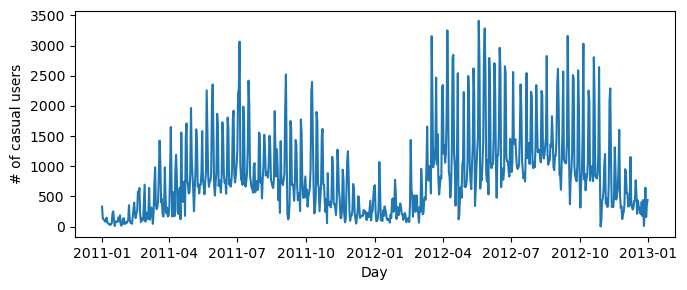

In [16]:
# import datetime
fig, ax = plt.subplots(1, figsize = (7, 3))
ax.plot(pd.to_datetime(bikeshare['dteday']), bikeshare['casual'])
ax.set(xlabel = "Day", ylabel = "# of casual users")
l = plt.tight_layout()

Now, let's work with a smaller subset of columns: 

In [17]:
cols = ["casual", 
        "mnth", 
        "weathersit", 
        "workingday",
        "yr",
        "temp", 
        "hum", 
        "windspeed",
        "holiday"]

bikeshare = bikeshare[cols]

bikeshare = pd.get_dummies(bikeshare, columns = ['mnth'], drop_first = "if_binary")
bikeshare

,casual,weathersit,workingday,yr,temp,hum,windspeed,holiday,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,331,2,0,0,0.344167,0.805833,0.160446,0,0,0,0,0,0,0,0,0,0,0,0
1,131,2,0,0,0.363478,0.696087,0.248539,0,0,0,0,0,0,0,0,0,0,0,0
2,120,1,1,0,0.196364,0.437273,0.248309,0,0,0,0,0,0,0,0,0,0,0,0
3,108,1,1,0,0.200000,0.590435,0.160296,0,0,0,0,0,0,0,0,0,0,0,0
4,82,1,1,0,0.226957,0.436957,0.186900,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,247,2,1,1,0.254167,0.652917,0.350133,0,0,0,0,0,0,0,0,0,0,0,1
727,644,2,1,1,0.253333,0.590000,0.155471,0,0,0,0,0,0,0,0,0,0,0,1
728,159,2,0,1,0.253333,0.752917,0.124383,0,0,0,0,0,0,0,0,0,0,0,1
729,364,1,0,1,0.255833,0.483333,0.350754,0,0,0,0,0,0,0,0,0,0,0,1


Now that our data is clean, let's split the data into test data and training data: 

In [18]:
train, test = train_test_split(bikeshare, test_size = .2, shuffle = False)

X_train = train.drop(["casual"], axis = 1)
y_train = train["casual"]

X_test = test.drop(["casual"], axis = 1)
y_test = test["casual"]

We can then run linear regression on the bikeshare training data. I chose to run regression using the analytical method, becuase the gradient descent runtime seemed to be much longer.

In [23]:
LR_bike = LinearRegression()
LR_bike.fit_analytical(X_train, y_train)

array([ -108.37113627,  -791.69054913,   280.58692733,  1498.71511272,
        -490.10033978, -1242.80038075,  -235.87934918,    -3.35439712,
         369.27195552,   518.40875345,   537.30188616,   360.80799815,
         228.88148125,   241.31641202,   371.50385387,   437.60084787,
         252.43300405,    90.8214605 ,   919.07676215])

Now let's compute the score:

In [24]:
print(f"Training score = {LR_bike.score(X_train, y_train).round(4)}")

Training score = 0.7318


The training score is fairly high! Now let's compute the predictions for each day and visualize them in relation to the actual ridership on the test set: 

In [39]:
print(len(y_test)) #147 days will be predicted and then compared

147


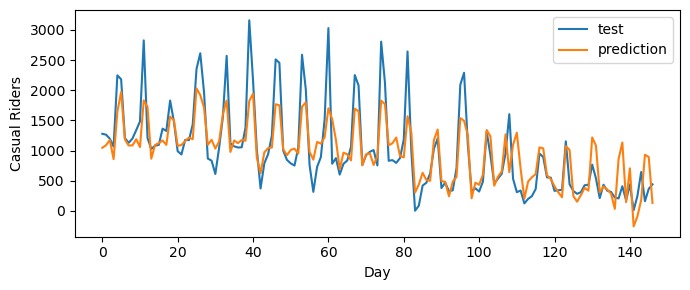

In [41]:
y_pred = LR_bike.predict(X_test) #predicitons on the test data. 

fig, ax = plt.subplots(1, figsize = (7, 3))
ax.plot(np.arange(len(y_test)), y_test, label="test") #test data
ax.plot(np.arange(len(y_test)), y_pred, label="prediction") #model prediction data
ax.set(xlabel = "Day", ylabel = "Casual Riders")
l = plt.tight_layout()

legend = plt.legend()

Our predicitons (orange) coorespond pretty well with the test data (blue). Now, we will compare the entries w to the entries in X_train.columns to see which features our model thinks best predict ridership. 

In [42]:
LR_bike.w

array([ -108.37113627,  -791.69054913,   280.58692733,  1498.71511272,
        -490.10033978, -1242.80038075,  -235.87934918,    -3.35439712,
         369.27195552,   518.40875345,   537.30188616,   360.80799815,
         228.88148125,   241.31641202,   371.50385387,   437.60084787,
         252.43300405,    90.8214605 ,   919.07676215])

In [43]:
X_train.columns

Index(['weathersit', 'workingday', 'yr', 'temp', 'hum', 'windspeed', 'holiday',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')

The most negative coeficient is windspeed, and the most positive coeficient is temperature. Thus, windspeed is the factor that most deters causal useres from biking, and temperature is the one that most entices these users to biking. Our model predicts that people want to bike more when it is warm outside, and less when it is windy. Our model also identifies factors such as workday and humidity as having negative relationships with the number of casual riders. Thus, we predict that less people are likely to bike outside of the weekends, and also if humidity is high. On the flip side, our model predicts a positive coorelation between the number of casual riders and the months of March and April, indicating that casual riders might be more likely to bike and get outside once the weather starts becoming nicer in the springtime. Cool! 